In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as graph
import seaborn as sns
import scipy.stats as scipy_stats

import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression

import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as Strvector

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats as stats_models

from tqdm import tnrange, tqdm_notebook, trange, tqdm
import itertools

################ Python R Combinations ##############
from rpy2.robjects import pandas2ri
pandas2ri.activate()
R = robjects.r

################ R Packages#######################
trend = rpackages.importr('trend')
segmented = rpackages.importr('segmented')
r_stats = rpackages.importr('stats')
sizer = rpackages.importr('SiZer')

# Get Data Ready

In [ ]:
# Get lakes Name

df = pd.read_csv('/mnt/c/Users/imrit/Downloads/lakeicephenology-master/lakeicephenology-master/69_lakes_ts_minimal.csv')
df = df[['lakecode', 'lake']].drop_duplicates()
df.to_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Lakecodes_lakenames.csv', index=False)
lakecodes_unique = df['lakecode'].unique()
lakenames_unique = df['lake'].unique()
print(len(lakecodes_unique), len(lakenames_unique))

In [ ]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/lakeicephenology-master/lakeicephenology-master/all_lakes_ts_reduced.csv')
df = df[['lakecode', 'lake', 'start_year', 'froze', 'ice_on_doy', 'ice_off_doy', 'total_duration']]
df = df[df['lakecode'].isin(lakecodes_unique)]
df = df[df['lake'] != 'detroit'] # Remove detroit
df = df.loc[df['start_year'] > 1833]
display(df.head())
print(len(df['lake'].unique()))

In [ ]:
graph.figure(figsize=(12,5))
graph.hist(df['ice_on_doy'], label='Ice-ON', alpha=0.5)
graph.hist(df['ice_off_doy'], label='Ice-OFF', alpha=0.5)
graph.legend()
graph.show()

In [ ]:
# Fill extremes with max for ice_on and min for ice_off

df['ice_on_doy'] = np.where(df['froze'] == 'N', df['ice_on_doy'].max(), df['ice_on_doy'])
df['ice_off_doy'] = np.where(df['froze'] == 'N', df['ice_off_doy'].min(), df['ice_off_doy'])

In [ ]:
graph.figure(figsize=(12,5))
graph.hist(df['ice_on_doy'], label='Ice-ON', alpha=0.5)
graph.hist(df['ice_off_doy'], label='Ice-OFF', alpha=0.5)
graph.legend()
graph.show()

In [ ]:
for col in ['ice_on_doy', 'ice_off_doy', 'total_duration']:
    df_var = df[['lake', 'start_year', 'froze', col]]
    df_transposed = df_var.pivot(index='lake', columns='start_year', values=col)
    df_transposed.dropna(thresh=0.3*(len(df_transposed.columns) - 1), inplace=True)
    number_lakes = len(df_transposed)
    df_transposed.reset_index(level=0, inplace=True)
#     df_transposed.to_csv(f'/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/Data/{number_lakes}_lakes_{col}_oct_09.csv', 
#                          index=False)
    print(col, number_lakes)
    display(df_transposed.head())

# 15 year moving window and sens slope

In [4]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/'

for file in os.listdir(f'{path}Data'):
    variable = file.split('lakes_')[1].split('_oct')[0]
    print(variable)
    df = pd.read_csv(f'{path}Data/{file}')
    df = df.T
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    df['start_year'] = df.index
    df = df[['start_year'] + [col for col in df.columns if col != 'start_year']]
    lake_names = df.columns[1:]
    
    new_sens = []
    new_sizer = []
    
    ! mkdir /mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/Analysis/Segmented/Data/{variable}
    
    for lake in lake_names:
        lake_df = df[['start_year', lake]]
        lake_df.dropna(inplace=True)
        rol_15 = lake_df.rolling(window=15).std()
        rol_15.dropna(inplace=True)
        rol_15['start_year'] = rol_15.index.astype(float)
        
        # Sens slopes
        r_var = robjects.IntVector(rol_15[lake].dropna())
        sens = trend.sens_slope(r_var)
        slope_sens = np.array(sens[0]).item()
        p_sens = np.array(sens[2]).item()
        new_sens.append([lake, slope_sens, p_sens])
        
        # sizer data
        linear_piecewise = sizer.piecewise_linear(rol_15['start_year'],rol_15[lake])
        sizer_aic = r_stats.AIC(linear_piecewise).item()
        break_year = linear_piecewise[0].item()
        new_sizer.append([lake, break_year, sizer_aic])
        
        # make csv files for R
        
        rol_15.rename(columns={lake: 'lake'}, inplace=True)
        rol_15['lake_name'] = lake
        rol_15['sizer_break_year'] = round(break_year)
        rol_15.to_csv(f'{path}Analysis/Segmented/Data/{variable}/{lake}_{variable}_rol_std_win_15.csv', index=False)
        
    sens_df = pd.DataFrame(new_sens)
    sens_df.rename(columns={0: 'lake', 1: 'slope', 2: 'p_value'}, inplace=True)
    print(len(sens_df))
    display(sens_df.head())
    sens_df.to_csv(f'{path}Analysis/{variable}_rolling_15_std_sens_variability_project_nov_16_2020.csv', index=False)
    
#     sizer_df = pd.DataFrame(new_sizer)
#     sizer_df.rename(columns={0: 'lake', 1: 'break_year', 2: 'sizer_aic'}, inplace=True)

total_duration


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


42


,lake,slope,p_value
0,aegerisee,-0.352941,4.300161e-04
1,baikal,0.027778,1.145951e-08
2,balaton,-0.047619,1.400495e-07
3,baldeggersee,0.000000,4.233776e-08
4,bayfield,0.041667,3.747388e-04


ice_on_doy
43


,lake,slope,p_value
0,aegerisee,-0.066667,2.566102e-05
1,baikal,0.000000,3.663717e-02
2,balaton,0.080000,8.551359e-03
3,baldeggersee,-0.270552,1.805158e-14
4,bayfield,0.048387,3.940113e-08


ice_off_doy
67


,lake,slope,p_value
0,aegerisee,-0.222222,0.001483
1,auburn,0.000000,0.082648
2,baikal,0.000000,0.015778
3,balaton,-0.023810,0.001324
4,baldeggersee,0.000000,0.534084


total_duration


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24

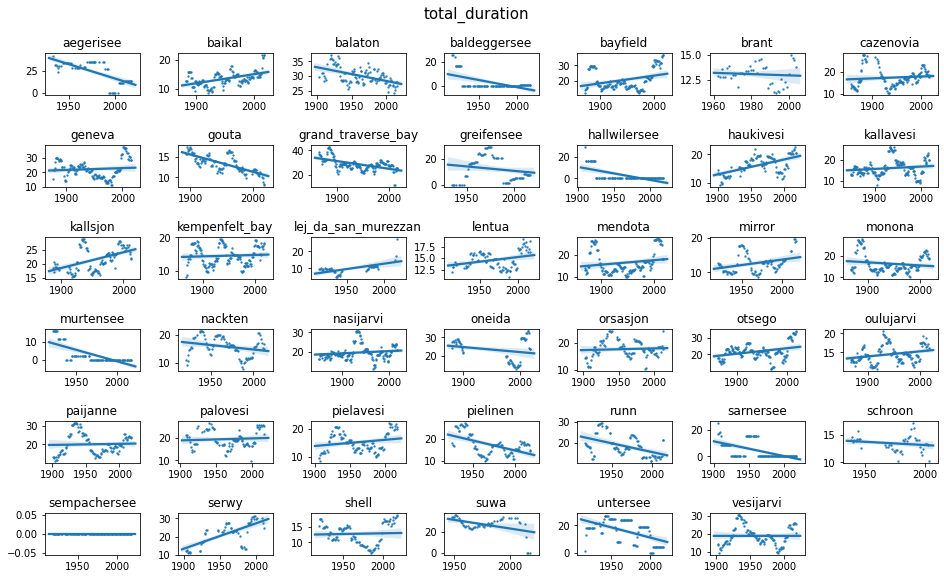

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24

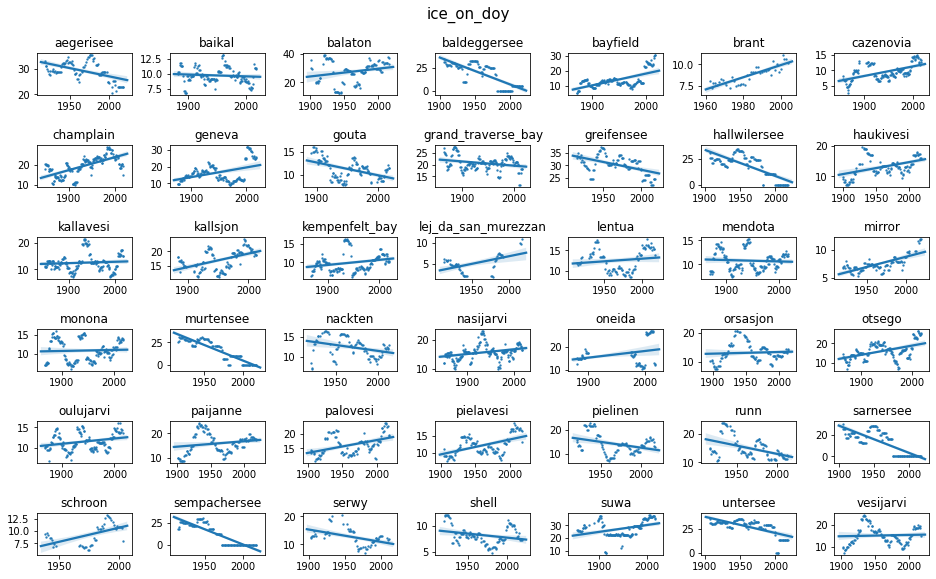

ice_off_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24

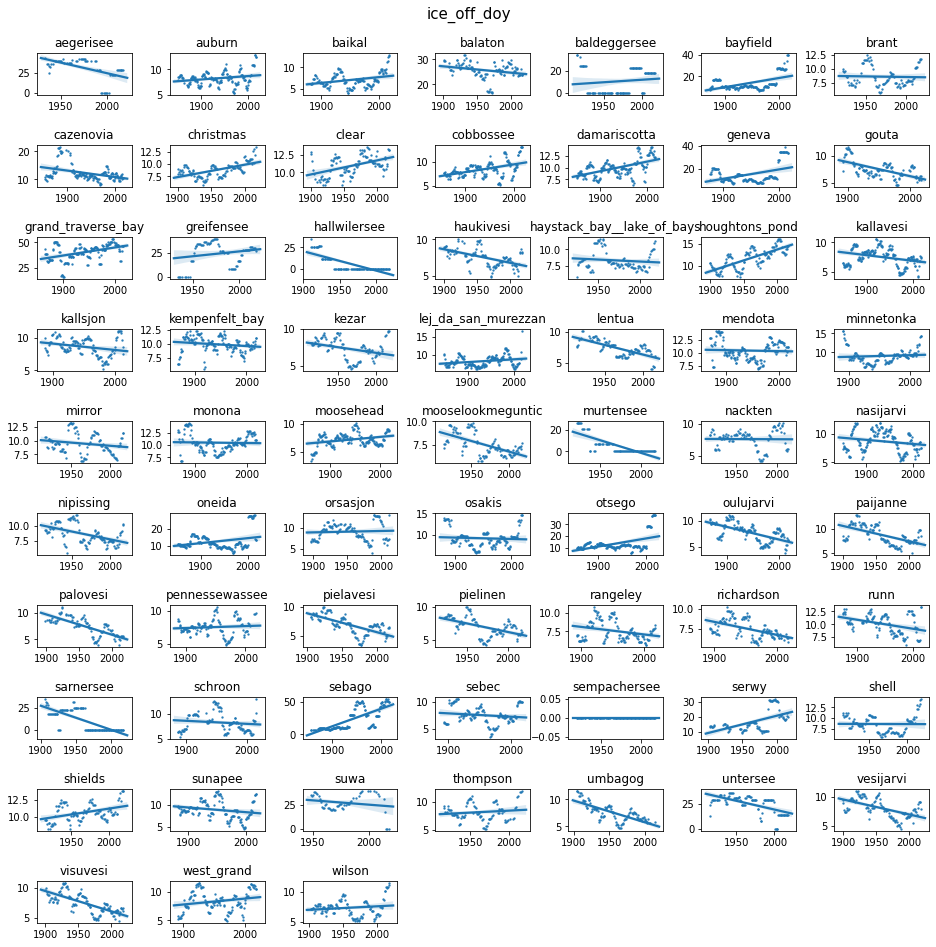

In [3]:
# make graphs in for loop

path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/'

for file in os.listdir(f'{path}Data'):
    variable = file.split('lakes_')[1].split('_oct')[0]
    print(variable)
    df = pd.read_csv(f'{path}Data/{file}')
    df = df.T
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    df['start_year'] = df.index
    df = df[['start_year'] + [col for col in df.columns if col != 'start_year']]
    lake_names = df.columns[1:]
    
    new_sens = []
    
#     fig, axes = graph.subplots(ncols=7, nrows=10, figsize=(16, 16))
    fig = graph.figure(figsize=(16, 16))
    
#     for lake, ax in zip(lake_names, axes.flat):

    for lake, i in zip(lake_names, range(1, len(lake_names))):
        lake_df = df[['start_year', lake]]
        lake_df.dropna(inplace=True)
        rol_15 = lake_df.rolling(window=15).std()
        rol_15.dropna(inplace=True)
        rol_15['start_year'] = rol_15.index.astype(float)
        
        #plot graphs
        ax = fig.add_subplot(10, 7, i)
        ax.set_title(lake)
        sns.regplot(rol_15['start_year'], rol_15[lake], ax=ax, scatter_kws={'s': 2})
        ax.set_ylabel('')
        ax.set_xlabel('')

    fig.subplots_adjust(wspace=0.4, hspace=1.2, top=0.88)
    fig.suptitle(variable, fontsize=15, y=0.92)
    fig.savefig(f'{path}Analysis/Sens_slope/{variable}_std_linear_regress_nov_15_2020.png', bbox_inches= 'tight')
    graph.show()

# Standard Deviation

In [86]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/'
swiss_lakes = ['aegerisee', 'baldeggersee', 'greifensee', 'hallwilersee', 'sarnersee', 'sempachersee', 'sunapee', 'untersee']

for file in os.listdir(f'{path}Data'):
    variable = file.split('lakes_')[1].split('_oct')[0]
    df = pd.read_csv(f'{path}Data/{file}')
    df = df.T
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])

    stan_dev_df = pd.DataFrame(df.std(), columns=['stan_dev'])
    stan_dev_df['lake'] = stan_dev_df.index
    stan_dev_df = stan_dev_df[['lake', 'stan_dev']]
    display(stan_dev_df.head())
#     stan_dev_df.to_csv(f'{path}Analysis/Standard_deviation/standard_dev_{variable}_variability_nov_13.csv', index=False)

,lake,stan_dev
aegerisee,aegerisee,28.644737
baikal,baikal,15.663543
balaton,balaton,30.402748
baldeggersee,baldeggersee,10.820512
bayfield,bayfield,29.497891


,lake,stan_dev
aegerisee,aegerisee,30.346244
baikal,baikal,11.039656
balaton,balaton,29.887424
baldeggersee,baldeggersee,24.589561
bayfield,bayfield,19.923410


,lake,stan_dev
aegerisee,aegerisee,33.968361
auburn,auburn,9.735440
baikal,baikal,8.184107
balaton,balaton,26.430222
baldeggersee,baldeggersee,17.857449


# Make Graphs

ice_off_doy


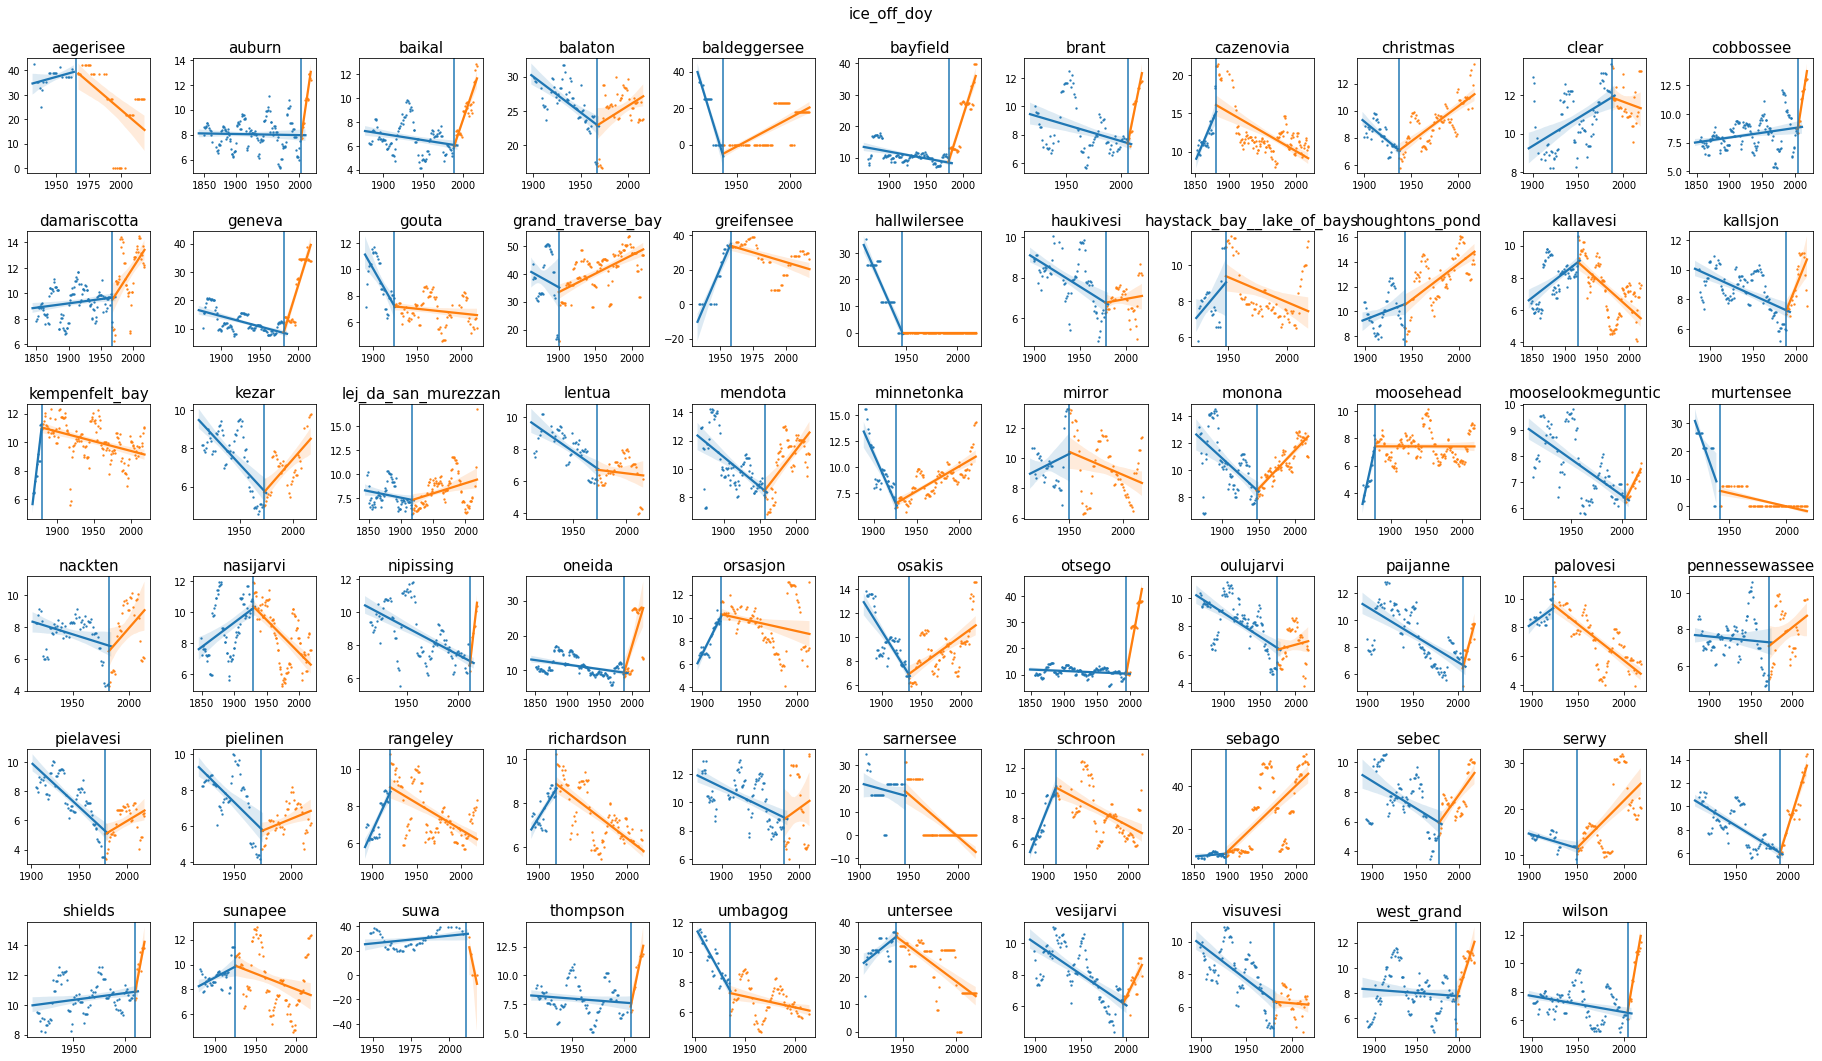

In [13]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/Analysis/'

variable_df = []
for variable in ['ice_off_doy', 'ice_on_doy', 'total_duration']:
    print(variable)
    
    if variable == 'ice_off_doy':
        fig = graph.figure(figsize=(32, 18))
    else:
        fig = graph.figure(figsize=(21, 21))
    
    for file, i in zip(os.listdir(f'{path}Segmented/Data/{variable}'), 
                       range(1, len(os.listdir(f'{path}Segmented/Data/{variable}')))):
        lake_name = file.split(f'_{variable}')[0]
        lake_df = pd.read_csv(f'{path}Segmented/Data/{variable}/{file}')
        pre_break_year = lake_df.loc[lake_df['start_year'] < lake_df['sizer_break_year'].mean()]
        post_break_year = lake_df.loc[lake_df['start_year'] >= lake_df['sizer_break_year'].mean()]
        
        #plot graphs
        if variable == 'ice_off_doy':
            ax = fig.add_subplot(6, 11, i)
        else:
            ax = fig.add_subplot(10, 7, i)
        ax.set_title(lake_name, fontsize=15)
        sns.regplot(pre_break_year['start_year'], pre_break_year['lake'], ax=ax, scatter_kws={'s': 2})
        sns.regplot(post_break_year['start_year'], post_break_year['lake'], ax=ax, scatter_kws={'s': 2}, 
                    truncate=True)
        graph.axvline(lake_df['sizer_break_year'].mean())
        ax.set_ylabel('')
        ax.set_xlabel('')

    fig.subplots_adjust(wspace=0.35, hspace=0.5, top=0.88)
    fig.suptitle(variable, fontsize=15, y=0.92)
    fig.savefig(f'{path}Graphs/{variable}_std_segmented_linear_regress_dec_04_2020.png', bbox_inches= 'tight')
    graph.show()
    break

In [23]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/Analysis/'

break_years_df = []
for variable in ['ice_off_doy', 'ice_on_doy', 'total_duration']:
    print(variable)

    for file in os.listdir(f'{path}Segmented/Data/{variable}'):
        lake_name = file.split(f'_{variable}')[0]
        lake_df = pd.read_csv(f'{path}Segmented/Data/{variable}/{file}')
        break_years_df.append([variable, lake_name, lake_df['sizer_break_year'].max()])
        
break_years_df = pd.DataFrame(break_years_df, columns=['variable', 'lake_name', 'break_year'])
display(break_years_df.head())
break_years_df.to_csv(f'{path}Segmented/variability_break_years_dec_07.csv', index=False)

ice_off_doy
ice_on_doy
total_duration


,variable,lake_name,break_year
0,ice_off_doy,aegerisee,1965
1,ice_off_doy,auburn,2003
2,ice_off_doy,baikal,1989
3,ice_off_doy,balaton,1967
4,ice_off_doy,baldeggersee,1937


# Map

In [102]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/ice_off_break_year_variability_lat_long.csv')
print(df.dtypes)
display(df.head())
print(f"Lat= {df['latitude'].min(), df['latitude'].max()}")
print(f"Long= {df['longitude'].min(), df['longitude'].max()}")

variable       object
lake_name      object
break_year      int64
latitude      float64
longitude     float64
dtype: object


,variable,lake_name,break_year,latitude,longitude
0,ice_off_doy,aegerisee,1965,47.8708,13.5481
1,ice_off_doy,auburn,2003,44.1446,-70.2513
2,ice_off_doy,baikal,1989,53.5587,108.1650
3,ice_off_doy,balaton,1967,46.8303,17.7340
4,ice_off_doy,baldeggersee,1937,47.2003,8.2600


Lat= (36.048789, 65.67)
Long= (-113.5215, 138.0859)


In [100]:
df['latitude'].min()

36.048789

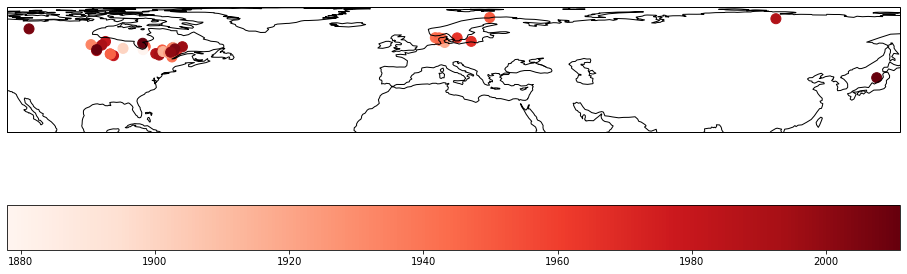

In [115]:
graph.figure(figsize=(16, 9))

plot_1 = graph.axes(projection=ccrs.LambertCylindrical())
plot_1.coastlines()
# plot_1.stock_img()
plot_1.set_extent([-120, 145, 20, 80], crs=ccrs.LambertCylindrical())
# plot_1.set_global()
graph.scatter(df['longitude'], df['latitude'], c= df['break_year'], 
              s=100, cmap='Reds', transform=ccrs.LambertCylindrical())
graph.colorbar(orientation='horizontal')
# graph.show()

# graph.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
# graph.scatter(lakes_lat_longs['Latitude'], lakes_lat_longs['Longitude'], transform=ccrs.Robinson(central_longitude=0, globe=None))
# graph.show()

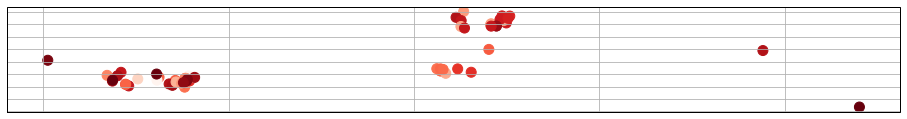

In [114]:
graph.figure(figsize=(16, 9))

plot_1 = graph.axes(projection=ccrs.EqualEarth())
plot_1.coastlines(resolution='110m')
plot_1.gridlines()
plot_1.scatter(df['longitude'], df['latitude'], c= df['break_year'], 
              s=100, cmap='Reds', transform=ccrs.EqualEarth())

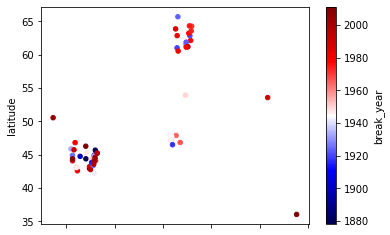

In [77]:
df.plot.scatter('longitude', 'latitude', c='break_year', colormap='seismic')